# <center>Анализ акустических событий</center>
# <center> Первая лабораторная работа </center>

In [16]:
import numpy as np
import scipy
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import librosa.filters
from glob import glob
import os

import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import learning_curve


# Подготовка к классификации

### Загрузим один из файлов

In [17]:
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
#draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

In [18]:
def mel(spec):
    return np.array(2595 * np.log10(1 + spec/700))

In [19]:
def mel_filters_librosa(sr, n_fft, n_mels):
    fmax = float(sr) / 2
    fmin = 0
    m = np.linspace(mel(fmin), mel(fmax), num=n_mels+2)
    h = 700.0 * (10.0 ** (m / 2595.0) - 1.0)
    f_bank = np.zeros((n_mels, int(n_fft/2) + 1))
    fft_freqs = np.linspace(0, sr / 2, 1 + n_fft // 2)
    f_diff = np.diff(h)
    ramps = np.subtract.outer(h, fft_freqs)

    for i in range(n_mels):
        lower = -ramps[i] / f_diff[i]
        upper = ramps[i + 2] / f_diff[i + 1]
        f_bank[i] = np.maximum(0, np.minimum(lower, upper))

    enorm = 2.0 / (h[2:n_mels + 2] - h[:n_mels])
    f_bank *= enorm[:, np.newaxis]
    return f_bank

In [20]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_ms * sr//1000
    spec = np.abs(librosa.stft(wav, n_fft=n_fft,
                  hop_length=hop_length, window='hann', center=True))**2
    mel_filters = mel_filters_librosa(sr, n_fft, n_fbanks)
    return np.dot(mel_filters, spec)

In [21]:
window_ms = 25
step_ms = 10
n_fbanks = 40
n_fft = window_ms * sr//1000
hop_length = step_ms * sr//1000

In [22]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_mfcc=13):
    # YOUR CODE HERE
    fbanks = get_fbanks(wav, sr, window_ms, step_ms, 128)
    log_spec = librosa.power_to_db(fbanks)
    mel_coeff = scipy.fftpack.dct(
        log_spec, axis=0, type=2, norm='ortho')[:n_mfcc]
    return mel_coeff

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [23]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)    
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста

In [24]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *5 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре.
Реализуйте простой VAD. Настройте VAD, чтобы хорошо определялись границы слов.

Подсказка:
Можно отличать паузу от речи по энергии mfcc спектра( или части спектра). Чтобы предотвратить скачки на краях слов, воспользуйтесь сверткой со сглаживающим окном, например, Ханна.

In [25]:
def VAD(wav, sr, threshold):
    mfcc = get_mfcc(wav, sr, window_ms=25, step_ms=10)[1]
    mfcc = np.repeat(mfcc, step_ms * sr//1000)
    mfcc = np.resize(mfcc, len(wav))

    wind = scipy.signal.get_window("hann", 3000)
    mfcc_wind = np.convolve(mfcc, wind, 'same')/3000
    vad = np.zeros(len(mfcc_wind))
    vad[mfcc_wind > threshold] = 1
    return vad

train_VA = [VAD(x, sr, 96) for x in X_train]
test_VA = [VAD(x, sr, 96) for x in X_test]

In [26]:
def test_VAD(VOICE, VA, Y, min_acc=0.95):
    def check_ali(ali, num_words):
        diff = ali[1:]  - ali[:-1]
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() == num_words:
            return -2
        return 0
    
    bad_i = []
    err =0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        assert len(VOICE[i]) == len(ali), "shapes doesn't match"
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err+=1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) >0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc , f"Accuracy must be >= {min_acc}"
    print("Test passed")

test_VAD(X_train, train_VA, Y_train)
test_VAD(X_test, test_VA, Y_test)
print("VAD ok!")

Accuracy 1.0
Test passed
Accuracy 1.0
Test passed
VAD ok!


# Задание *6 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95

In [27]:
# YOUR CODE HERE
def get_bounds(x_vad):
    bounds = [i for i in range(1, len(x_vad)) if x_vad[i] != x_vad[i-1]]
    return np.array(bounds)


def pre_process(x, y, vad, sr=22050):
    x_new, y_new = [], []
    words_bounds = get_bounds(vad)

    for j in range(0, len(words_bounds), 2):
        word = x[words_bounds[j]:words_bounds[j+1]]
        word_mfcc = get_mfcc(word, sr)
        x_new.append(np.mean(word_mfcc, axis=1))
        y_new.append(y[j//2])
    return x_new, y_new

In [28]:
x_train, y_train = [], []
for (x, y, vad) in zip(X_train, Y_train, train_VA):
    x_new, y_new = pre_process(x, y, vad)
    x_train.extend(x_new)
    y_train.extend(y_new)
x_test, y_test = [], []
for (x, y, vad) in zip(X_test, Y_test, test_VA):
    x_new, y_new = pre_process(x, y, vad)
    x_test.extend(x_new)
    y_test.extend(y_new)

In [29]:
svc = SVC(random_state=2)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Результаты

Визуализируйте кривые обучения классификатора или приведите логи обучения

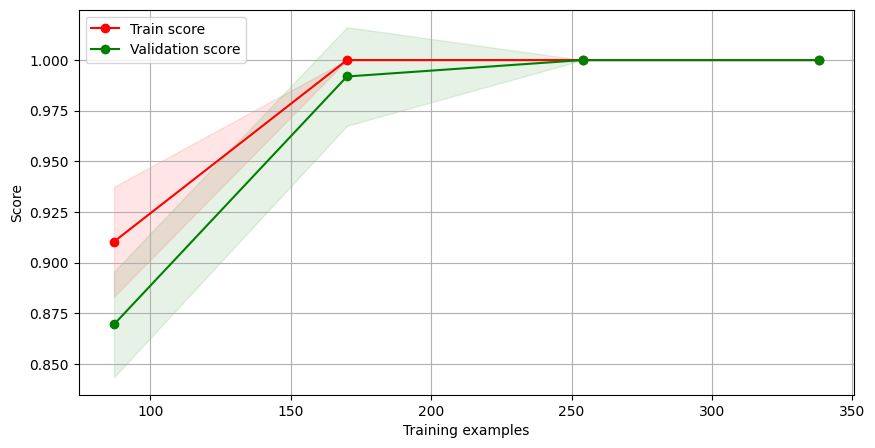

In [30]:
# YOUR CODE HERE
train_sizes, train_scores, test_scores = learning_curve(
    svc, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
axes.grid()
axes.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)

axes.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Train score")
axes.plot(train_sizes, test_scores_mean, "o-",
          color="g", label="Validation score")
axes.legend(loc="best")